In [ ]:
!pip install unsloth==2025.5.7 unsloth-zoo==2025.5.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1

In [ ]:
#!/usr/bin/env python3
"""
Annotate a CSV of comments with toxicity labels using Gemma-3 + LoRA adapters.
"""

import logging
from pathlib import Path
from typing import Tuple

import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import TextStreamer
from unsloth import FastModel
from peft import PeftModel
from unsloth.chat_templates import get_chat_template

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s ▶ %(message)s")
LOGGER = logging.getLogger(__name__)

SYSTEM_PROMPT = (
    'You are a toxicity detector – choose one label from '
    '["toxic","severe_toxic","obscene","threat","insult","identity_hate"]. '
    'If none apply, return NA.'
)

def load_toxicity_model(
    pretrained_model: str,
    lora_adapter: str,
    device: str = "cuda"
) -> Tuple[PeftModel, "PreTrainedTokenizer"]:
    """
    Load the base Gemma-3 4-bit model and attach a LoRA adapter for toxicity detection.
    """
    base_model, tokenizer = FastModel.from_pretrained(
        model_name=pretrained_model,
        max_seq_length=2048,
        load_in_4bit=True,
    )
    model = PeftModel.from_pretrained(
        base_model,
        lora_adapter,
        torch_dtype=torch.float16,
    ).eval().to(device)

    tokenizer = get_chat_template(tokenizer, chat_template="gemma-3")
    LOGGER.info("Loaded model %s with adapter %s on %s", pretrained_model, lora_adapter, device)
    return model, tokenizer



<ipython-input-4-4ced37b35a40>:14: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
def classify_comment(
    model: PeftModel,
    tokenizer,
    comment: str,
    device: str = "cuda"
) -> str:
    """
    Run a single comment through the model and return the predicted label.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": comment},
    ]
    prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs = tokenizer([prompt], return_tensors="pt").to(device)
    streamer = TextStreamer(tokenizer, skip_prompt=True)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=10,
        temperature=0.4,
        top_p=0.95,
        top_k=64,
        streamer=streamer,
    )
    label = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return label



In [ ]:
def annotate_file(input_csv: Path, output_csv: Path, model, tokenizer, device: str):
    """
    Read input CSV, classify each comment, and write out annotated CSV.
    """
    df = pd.read_csv(input_csv)
    tqdm.pandas(desc="Classifying comments")
    df["toxicity"] = df["comment_text"].progress_apply(
        lambda text: classify_comment(model, tokenizer, text, device)
    )
    df.to_csv(output_csv, index=False)
    LOGGER.info("Saved annotated CSV to %s", output_csv)



In [ ]:
if __name__ == "__main__":
    MODEL_NAME   = "unsloth/gemma-3-4b-it"
    LORA_ADAPTER = "Subhrato20/gemma-3-toxic-v2"
    DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

    INPUT_CSV  = Path("/content/test_samples.csv")
    OUTPUT_CSV = Path("/content/gemma_test_results.csv")

    model, tokenizer = load_toxicity_model(MODEL_NAME, LORA_ADAPTER, DEVICE)
    annotate_file(INPUT_CSV, OUTPUT_CSV, model, tokenizer, DEVICE)


==((====))==  Unsloth 2025.5.7: Fast Gemma3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/59.7M [00:00<?, ?B/s]

Classifying comments:   0%|          | 0/1000 [00:00<?, ?it/s]

NA<end_of_turn>
NA<end_of_turn>
Answer: NA<end_of_turn>
Answer: none<end_of_turn>
severe_toxic
<end_of_turn>
severe_toxic<end_of_turn>
Answer: NA<end_of_turn>
Answer: NA<end_of_turn>
Answer: NA<end_of_turn>
NA<end_of_turn>
Answer: NA<end_of_turn>
severe_toxic
<end_of_turn>
Answer: NA
<end_of_turn>
NA<end_of_turn>
Answer: NA<end_of_turn>
Answer: NA
<end_of_turn>
NA
<end_of_turn>
severe_toxic
<end_of_turn>
Answer: NA<end_of_turn>
severe_toxic
<end_of_turn>
severe_toxic
<end_of_turn>
Answer: none of the labels fit.<end_of_turn>
Answer: none of the above
<end_of_turn>
Answer: NA
<end_of_turn>
severe_toxic
<end_of_turn>
Answer: NA<end_of_turn>
NA<end_of_turn>
Answer: NA<end_of_turn>
NA
<end_of_turn>
NA
<end_of_turn>
NA
<end_of_turn>
NA
<end_of_turn>
NA
<end_of_turn>
severe_toxic
<end_of_turn>
NA<end_of_turn>
NA
<end_of_turn>
Answer: NA
<end_of_turn>
Answer: NA<end_of_turn>
NA<end_of_turn>
Answer: NA<end_of_turn>
Answer: NA<end_of_turn>
Answer: NA<end_of_turn>
Answer: toxic<end_of_turn>
NA<e

In [ ]:
df = pd.read_csv('/content/gemma_test_results.csv')
df['toxicity'] = df['toxicity'].apply(lambda x: str(x).split()[-1] if pd.notna(x) else 'NA')
df.to_csv(OUTPUT_CSV, index=False)
LOGGER.info("Cleaned toxicity column in %s", OUTPUT_CSV)

In [2]:
import pandas as pd

samples = pd.read_csv("test_samples.csv")
labels  = pd.read_csv("test_labels.csv")

merged = samples.merge(labels, on="id", how="left")

print(merged.head())
merged.to_csv("test_samples_with_labels.csv", index=False)

                 id                                       comment_text  toxic  \
0  d4ede52e6fc315a2  == Sky city == \n\n Hello, \n\n I noticed that...      0   
1  345bb5c81a8a6797  " \n\n ""Specifically, Allied forces suffered ...      0   
2  73ef403fa5a095e6  " \n You know what, I think you're just insecu...     -1   
3  d5290e73cf136173  " \n\n == LOL == \n\n LOLLOLOLOLOOLOLLOLOLOLLO...     -1   
4  d4911d1fd9989582  he is not a bad guy he is a sexy guy and his b...     -1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2            -1       -1      -1      -1             -1  
3            -1       -1      -1      -1             -1  
4            -1       -1      -1      -1             -1  


In [6]:

pred = pd.read_csv("gemma_test_results.csv")
truth = pd.read_csv("test_samples_with_labels.csv")

LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

def get_cluster(row):
    labs = [lab for lab in LABELS if (lab in row and row[lab] != -1 and row[lab] == 1)]
    return ",".join(labs) if labs else "none"

truth["cluster"] = truth.apply(get_cluster, axis=1)

row_has_valid_label = truth[LABELS].apply(lambda row: any([x != -1 for x in row]), axis=1)
truth_eval = truth[row_has_valid_label]

df = pred.merge(truth_eval[["id", "cluster"]], on="id", how="inner")

def is_correct(row):
    gt = str(row["cluster"]).strip().lower()
    pred = str(row["toxicity"]).strip().lower() if pd.notnull(row["toxicity"]) else "none"
    gt_set = set([g.strip() for g in gt.split(",")]) if gt and gt != "none" else set()
    if (not gt_set and (not pred or pred == "none")) or (pred in gt_set):
        return 1
    else:
        return 0


df["is_correct"] = df.apply(is_correct, axis=1)
accuracy = df["is_correct"].mean()

print(f"Loose cluster label accuracy (ignoring -1s): {accuracy:.4f}")

Loose cluster label accuracy (ignoring -1s): 0.8275



Binary confusion matrix ('none'=0, 'any toxic'=1):
            Pred none  Pred toxic
True none         322          40
True toxic         11          27


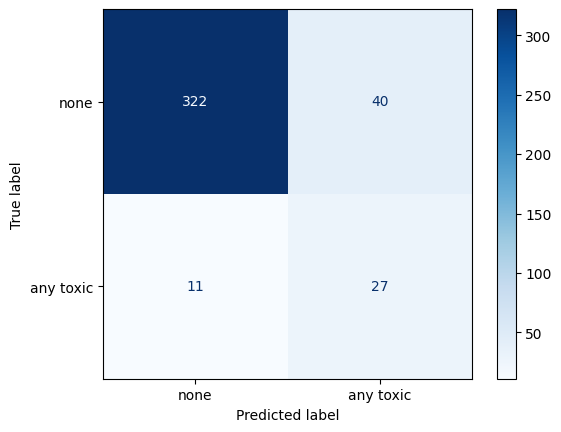

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def cluster_to_binary(cluster):
    return 0 if cluster == "none" else 1

def pred_to_binary(pred):
    return 0 if (pred is None or str(pred).strip().lower() in ["none", "nan", ""]) else 1

y_true_bin = df["cluster"].apply(cluster_to_binary)
y_pred_bin = df["toxicity"].apply(pred_to_binary)

cm = confusion_matrix(y_true_bin, y_pred_bin)
print("\nBinary confusion matrix ('none'=0, 'any toxic'=1):")
print(pd.DataFrame(cm, index=["True none", "True toxic"], columns=["Pred none", "Pred toxic"]))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["none", "any toxic"])
disp.plot(cmap="Blues")
plt.show()